In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from BPMN.optimization import *
torch.set_default_dtype(torch.float64)
from libSOGAtruncate import truncate
import time

import torch
from torch.distributions import Normal, Categorical
import math

import BPMN.data_generating_process as dgp
import BPMN.helper_plots as hp



['/home/rdoz/miniconda3/envs/myenv/lib/python313.zip', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13/lib-dynload', '', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13/site-packages', '/home/rdoz/PhD/DeGAS/src']


/home/rdoz/miniconda3/envs/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Execution time: 0.45633411407470703 seconds


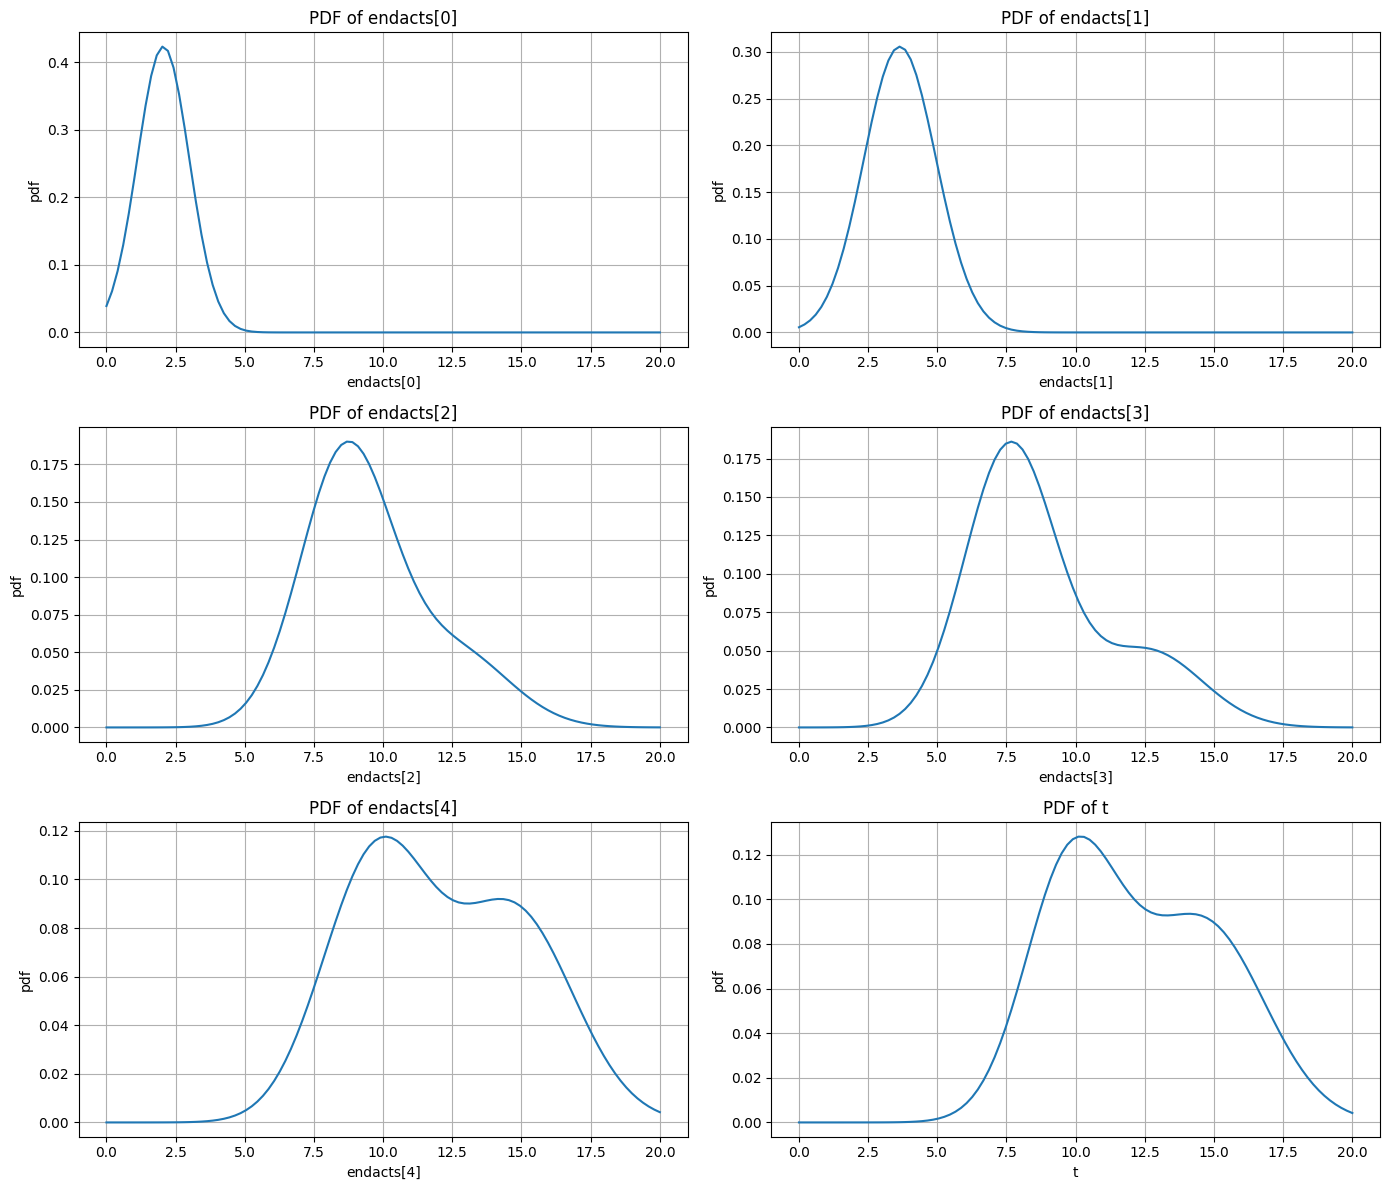

tensor([[0.1017]], grad_fn=<MmBackward0>)


In [ ]:
soga_code = """
array[5] tactivities;    
array[5] startacts;     
array[5] endacts;

/* Total time */
t = 0;

/* Resource capacity: either 1 or 2 (set externally) */
resourcerate2 = _resourcesrate * _resourcesrate;
R = 1 +  resourcerate2;    /* Allowed values: 1 or 2 */

/* =======================================================
   ACTIVITY 0 — COLLECT CUSTOMER INFORMATION (SEQUENTIAL)
   ======================================================= */

tactivities[0]  = _muinfo*_muinfo + gm([1], [0.], [1.]);
observe(tactivities[0] > 0.);  /* ensure positive durations */

/* No resource availability modelling here in Option 2,
   just start immediately in the sequential phase */
startacts[0] = t;
endacts[0]   = startacts[0] + tactivities[0];
t = endacts[0];


/* ============================
   ACTIVITY 1 — PAYMENT (XOR)
   ============================ */

switch2 = _switch * _switch;
   
if uniform([0., 1.], 2) - switch2 < 0. {
    /* Pay electronically */
    tactivities[1] = _mupayE *_mupayE + gm([1], [0],     [1.]);
} else {
    /* Pay standard */
    tactivities[1] = _mupayS *_mupayS + gm([1], [0],     [1.]);
} end if;

observe(tactivities[1] > 0.);  /* ensure positive durations */
/* Start immediately (no resource constraints in sequential phase) */
startacts[1] = t;
endacts[1]   = startacts[1] + tactivities[1];
t = endacts[1];


/* =====================================================
   PARALLEL BLOCK (3 ACTIVITIES): RESOURCE CAPACITY R
   ===================================================== */

/* Durations */
tactivities[2] = _mupack * _mupack + gm([1], [0.],    [1.]);
tactivities[3] = _muprepinv * _muprepinv + gm([1], [0.], [1.]);
tactivities[4] = _musendinv * _musendinv + gm([1], [0.], [1.]);
observe(tactivities[2] > 0.);  /* ensure positive durations */
observe(tactivities[3] > 0.);  /* ensure positive durations */
observe(tactivities[4] > 0.);  /* ensure positive durations */

/* Resource loads: when each resource becomes free */
resload0 = t;
resload1 = t;    /* used only if R = 2 */


/* ---------------------------------------------
   CASE TASK 2 (PREPARE PACKAGE) COMES BEFORE TASK 3 (PREPARE INVOICE)
   --------------------------------------------- */
if uniform([0., 1.], 2) < 0.5 {
    if R < 1.5 {

        startacts[2] = resload0;
        endacts[2]   = startacts[2] + tactivities[2];
        resload0     = endacts[2];

    } else {

        /* choose least loaded; random tie-break */
        if resload0 - resload1 < 0. {

            startacts[2] = resload0;
            endacts[2]   = startacts[2] + tactivities[2];
            resload0     = endacts[2];

        } else {

            startacts[2] = resload1;
            endacts[2]   = startacts[2] + tactivities[2];
            resload1     = endacts[2];

        } end if;

    } end if;


    /* ---------------------------------------------
    TASK 3 — PREPARE INVOICE
    --------------------------------------------- */

    if R < 1.5 {

        startacts[3] = resload0;
        endacts[3]   = startacts[3] + tactivities[3];
        resload0     = endacts[3];

    } else {

        if resload0 - resload1 < 0. {

            startacts[3] = resload0;
            endacts[3]   = startacts[3] + tactivities[3];
            resload0     = endacts[3];

        } else {

            startacts[3] = resload1;
            endacts[3]   = startacts[3] + tactivities[3];
            resload1     = endacts[3];

        } end if;

    } end if;
} else {
/* ---------------------------------------------
    TASK 3 — PREPARE INVOICE
    --------------------------------------------- */

    if R < 1.5 {

        startacts[3] = resload0;
        endacts[3]   = startacts[3] + tactivities[3];
        resload0     = endacts[3];

    } else {

        if resload0 - resload1 < 0. {

            startacts[3] = resload0;
            endacts[3]   = startacts[3] + tactivities[3];
            resload0     = endacts[3];

        } else {

            startacts[3] = resload1;
            endacts[3]   = startacts[3] + tactivities[3];
            resload1     = endacts[3];

        } end if;

    } end if;

    if R < 1.5 {

        startacts[2] = resload0;
        endacts[2]   = startacts[2] + tactivities[2];
        resload0     = endacts[2];

    } else {

        /* choose least loaded; random tie-break */
        if resload0 - resload1 < 0. {

            startacts[2] = resload0;
            endacts[2]   = startacts[2] + tactivities[2];
            resload0     = endacts[2];

        } else {

            startacts[2] = resload1;
            endacts[2]   = startacts[2] + tactivities[2];
            resload1     = endacts[2];

        } end if;

    } end if;
} end if;



/* ---------------------------------------------
   TASK 4 — SEND INVOICE
   --------------------------------------------- */

ready4 = endacts[3];   /* Task 4 can start only after Task 3 finishes */

if R < 1.5 {

    /* single resource */
    if resload0 - ready4 < 0. { startacts[4] = ready4; } else { startacts[4] = resload0; } end if;
    endacts[4] = startacts[4] + tactivities[4];
    resload0   = endacts[4];

} else {

    /* two resources: choose least loaded, but also respect ready4 */
    if resload0 - resload1 < 0. {

        if resload0 - ready4 < 0. { startacts[4] = ready4; } else { startacts[4] = resload0; } end if;
        endacts[4] = startacts[4] + tactivities[4];
        resload0   = endacts[4];

    } else {

        if resload1 - ready4 < 0. { startacts[4] = ready4; } else { startacts[4] = resload1; } end if;
        endacts[4] = startacts[4] + tactivities[4];
        resload1   = endacts[4];

    } end if;

} end if;



/* ----------------------------
   AND JOIN: t = max(resload0, resload1)
   ---------------------------- */

if R < 1.5 {
    t = resload0;
} else {
    if resload0 - resload1 > 0. {
        t = resload0;
    } else {
        t = resload1;
    } end if;
} end if;

"""

# the activities are: info, payment (E or S), pack, prep_inv, send_inv
params = {'muinfo':  2.,
          'mupayE':  1., 
          'mupayS':  3.,
          'mupack':  5., 
          'muprepinv':  4., 
          'musendinv':  2., 
          'resourcesrate': 0.5
          ,'switch': 0.4}

#square root all parameters to ensure positivity
for key in params:
    params[key] = params[key]**0.5
    
params_dict = initialize_params(params) 
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
#measure execution time

start_time = time.time()

output_dist = start_SOGA(cfg, params_dict) 

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

variables_to_plot = [
    "endacts[0]",
    "endacts[1]",
    "endacts[2]",
    "endacts[3]",
    "endacts[4]" ,
    "t"                   # total time or completion time
]

# -----------------------------------------------------
# CALL THE PLOTTING FUNCTION
# -----------------------------------------------------
hp.plot_grid_marginals(output_dist, variables_to_plot, x_min=0.0, x_max=20.0, num_points=100)
print(output_dist.gm.marg_pdf(torch.tensor([12.]), output_dist.var_list.index('t')))

Initial parameters:
muinfo: 2.0
mupayE: 1.0
mupayS: 3.0
mupack: 5.0
muprepinv: 4.0
musendinv: 2.0
resourcesrate: 0.5
switch: 0.4
muinfo: 1.4042135634201385 mupayE: 0.9900000127908595 mupayS: 1.7220508122171323 mupack: 2.2260679800300056 muprepinv: 1.9900000008234782 musendinv: 1.4042135636073914 resourcesrate: 0.7171067811855556 switch: 0.6424555277536895  loss: -0.1060980724968885
muinfo: 1.3943953953069272 mupayE: 0.9801733674823473 mupayS: 1.7122766248114538 mupack: 2.2161956003550087 muprepinv: 1.9801900375441264 musendinv: 1.3943954740035798 resourcesrate: 0.7238073637259808 switch: 0.652291787419824  loss: -0.2066185891547903
muinfo: 1.384479365515758 mupayE: 0.9702528628496211 mupayS: 1.7023832073325145 mupack: 2.2066648089986405 muprepinv: 1.9702765636577468 musendinv: 1.3844769106753128 resourcesrate: 0.7289869334499433 switch: 0.6622124933794058  loss: -0.21251653805760284
muinfo: 1.3745478241714197 mupayE: 0.9603245915176175 mupayS: 1.6924449524811007 mupack: 2.1978214301853

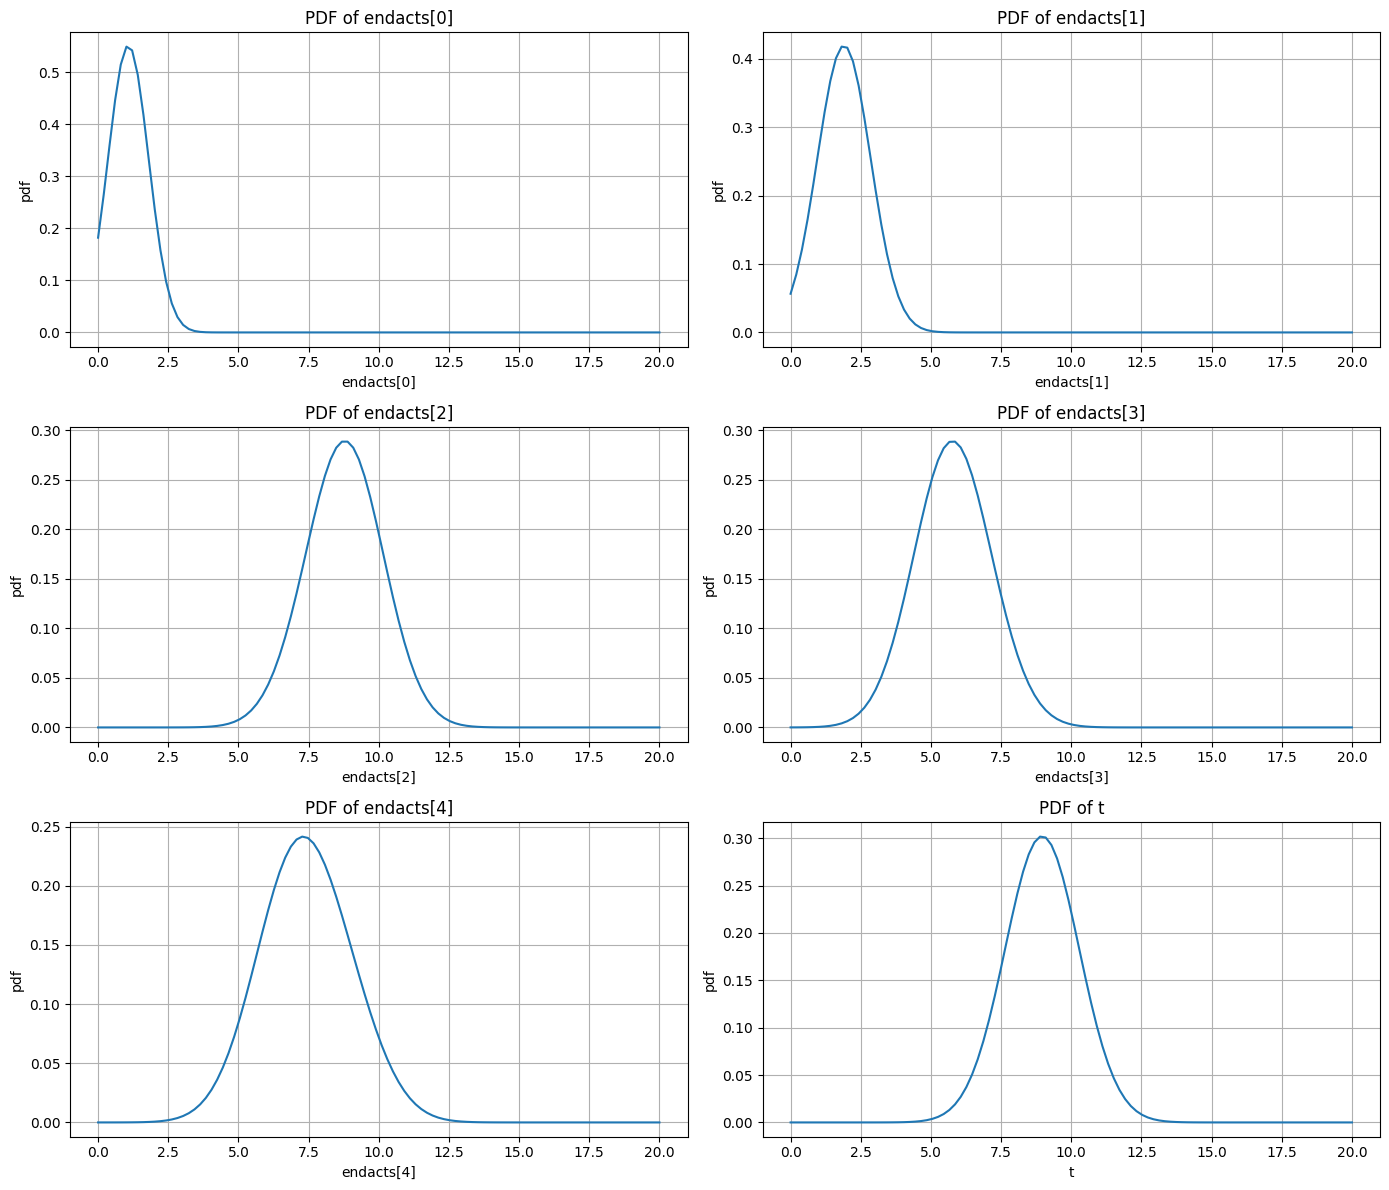

muinfo: 0.7967104910838607
mupayE: 0.0743214130911241
mupayS: 1.3815721542249164
mupack: 2.6185442030514774
muprepinv: 1.9728799720687347
musendinv: 1.2143541747228852
resourcesrate: 0.76715899883398
switch: 1.138494983364876


In [5]:
loss = lambda output_dist: -output_dist.gm.marg_pdf(torch.tensor([9.]), output_dist.var_list.index('t'))
# avoid optimizing mupack by setting to false the requires_grad flag
params = {'muinfo':  2.,
          'mupayE':  1., 
          'mupayS':  3.,
          'mupack':  5., 
          'muprepinv':  4., 
          'musendinv':  2., 
          'resourcesrate': 0.5
          ,'switch': 0.4}

print("Initial parameters:")
# print params
for key, value in params.items():
    print(f"{key}: {value}")


for key in params:
    params[key] = params[key]**0.5

params_dict = initialize_params(params) 

#params_dict['mupack'].requires_grad = False
#params_dict['muprepinv'].requires_grad = False
#params_dict['muprepinv'].requires_grad = False
#params_dict['musendinv'].requires_grad = False

#params_dict['mupayE'].requires_grad = False
#params_dict['mupayS'].requires_grad = False
#params_dict['switch'].requires_grad = False

start_time = time.time()
# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=100, lr=0.01)

end_time = time.time()
execution_time = end_time - start_time
print(f"Optimization execution time: {execution_time} seconds")

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

output_dist = start_SOGA(cfg, params_dict)
hp.plot_grid_marginals(output_dist, variables_to_plot, x_min=0.0, x_max=20.0, num_points=100)

for key in params:
    params[key] = params[key]**2

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")


In [11]:
endacts, startacts, tacts, meta = dgp.simulate_n(
        100,
        _muinfo=1.2,
        _mupayE=2.0,
        _mupayS=3.0,
        _mupack=1.0,
        _muprepinv=0.8,
        _musendinv=1.1,
        _switch=0.7,
        _resourcesrate=1.0
    )

print("endacts[0]:", endacts[0])
print("meta:", meta)

endacts[0]: tensor([ 3.0984,  7.2960,  9.1592,  9.0390, 10.1731])
meta: {'makespans': tensor([10.1731,  9.1624,  7.8116,  8.0310,  8.6764,  2.7042,  8.2875,  8.0516,
         4.2161,  5.0482,  4.8517,  7.3028,  5.6914,  6.5813,  4.1797,  7.4038,
         8.3464,  9.6894,  6.0372,  6.2166,  8.1373,  6.4900,  6.0061,  8.1603,
         8.5464,  6.4831,  6.3183,  8.3827,  8.4550,  8.3581,  5.4600,  7.3197,
         7.4141, 10.8918,  3.9831,  4.1766,  9.3381,  5.6963,  6.0735,  5.9895,
         7.9377,  6.8542,  6.7442,  8.1532,  7.3855,  7.4236,  9.0989,  5.0935,
         7.0645,  5.7239,  8.0757,  5.1248,  8.4044,  3.3250,  7.4259,  8.8280,
         6.8908,  5.5243,  7.2584,  6.3171,  7.1636,  5.7176,  7.2686,  6.8251,
         5.3245,  6.5004,  4.9970,  5.5886,  7.4927,  7.2456,  8.1604,  8.1239,
         4.1907,  6.9696,  5.6682,  4.2092,  9.1250,  5.3461,  7.7619,  3.8841,
         4.5784,  5.4742,  3.8797,  7.0131,  6.7725,  8.2260,  5.7151,  6.8701,
         7.9775,  7.8993,  6.9637,

In [12]:
# get the tensor with all the endacts (all torch)
clean_durations = []
for i in range(len(endacts)):
    clean_durations.append(endacts[i].numpy())
clean_durations = torch.tensor(clean_durations)
print("clean_durations:", clean_durations)

clean_durations: tensor([[ 3.0984,  7.2960,  9.1592,  9.0390, 10.1731],
        [ 2.6685,  7.3837,  8.0001,  7.5270,  9.1624],
        [ 2.2640,  4.4146,  7.8116,  5.3630,  7.1311],
        [ 1.7699,  6.2914,  8.0310,  7.4811,  7.5446],
        [ 1.1578,  5.3706,  8.6764,  7.2442,  7.5375],
        [ 1.2971,  1.3964,  1.9591,  1.6346,  2.7042],
        [ 3.2645,  6.7623,  7.2850,  7.2002,  8.2875],
        [ 1.8873,  4.1189,  4.5551,  6.0650,  8.0516],
        [ 1.6252,  2.3711,  3.0966,  2.9734,  4.2161],
        [ 1.3808,  2.7642,  3.8989,  3.5773,  5.0482],
        [ 0.7534,  1.9279,  3.9771,  2.6753,  4.8517],
        [ 1.9453,  2.1600,  2.2763,  4.9562,  7.3028],
        [ 1.7730,  4.4193,  5.6914,  5.1819,  5.4479],
        [ 0.7461,  3.4633,  5.5041,  5.0445,  6.5813],
        [ 1.9786,  3.6942,  3.9064,  3.7991,  4.1797],
        [ 1.7047,  3.2353,  4.2136,  5.5953,  7.4038],
        [ 2.5619,  6.0103,  6.7205,  7.3625,  8.3464],
        [ 3.3737,  6.8674,  7.0293,  7.9468,  9.

In [13]:
var_index = [output_dist.var_list.index('tactivities['+ str(i) +']') for i in range(5)]
loss = lambda dist : neg_log_likelihood(clean_durations, dist, var_index)

print(loss(output_dist))


tensor(2710.5649, grad_fn=<NegBackward0>)


ORIGINAL PARAMETERS

Execution time: 0.3889319896697998 seconds


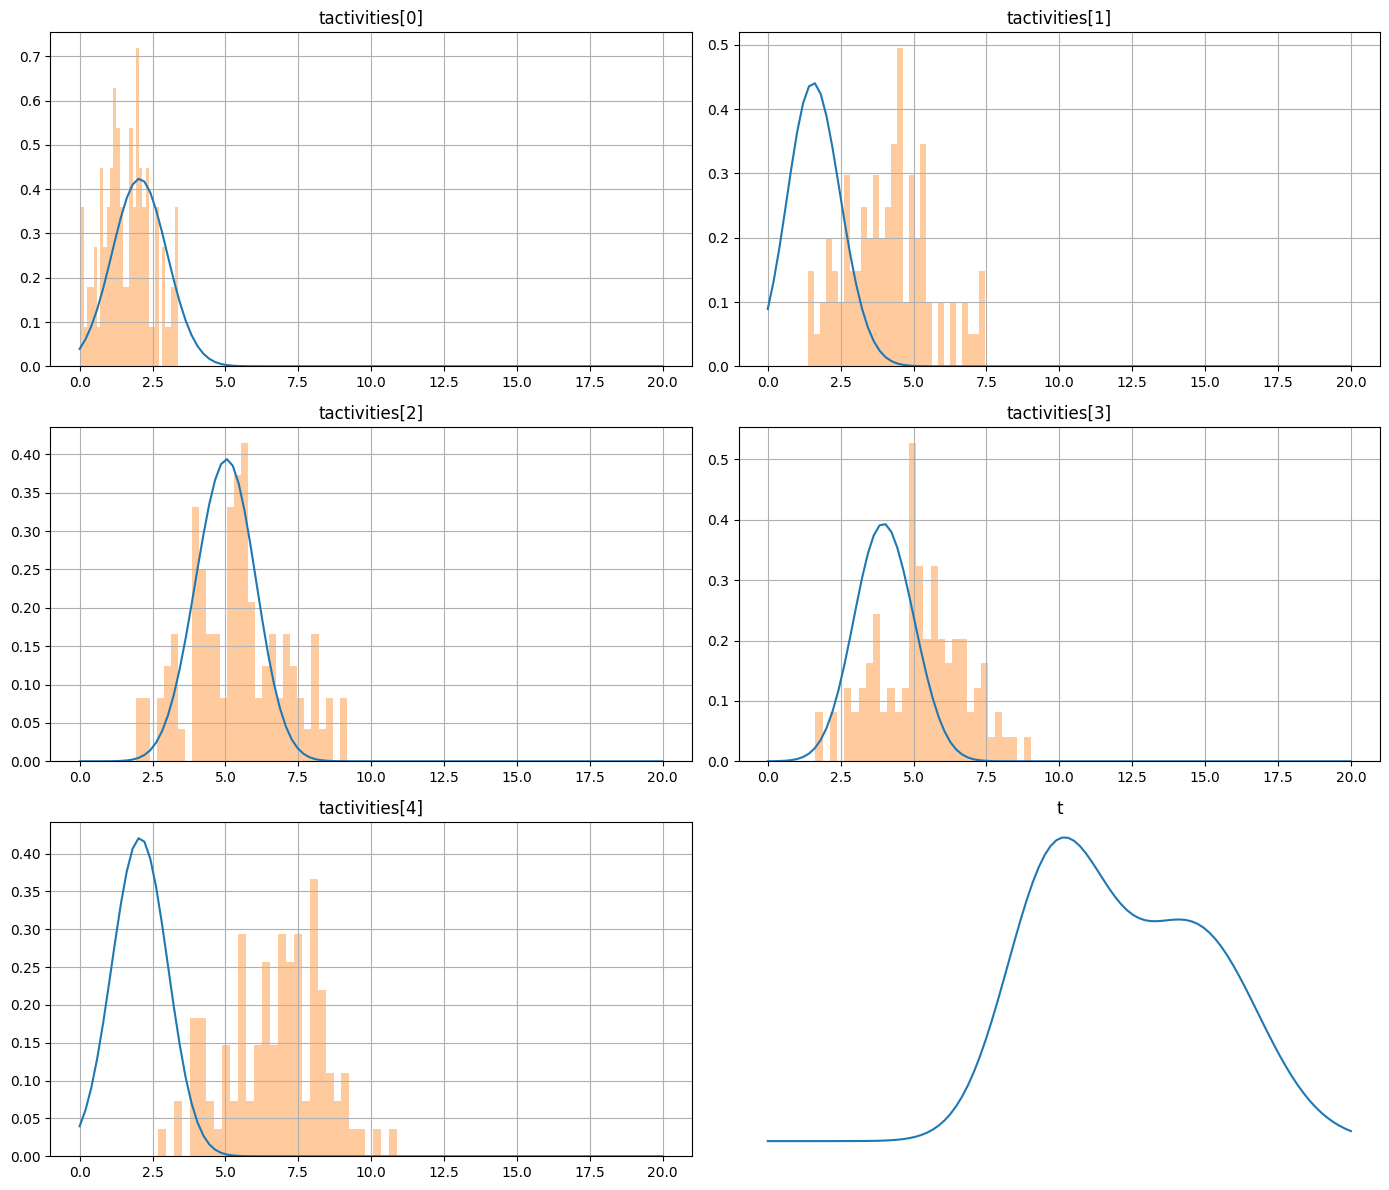

In [14]:
# the activities are: info, payment (E or S), pack, prep_inv, send_inv
params = {'muinfo':  2.,
          'mupayE':  1., 
          'mupayS':  3.,
          'mupack':  5., 
          'muprepinv':  4., 
          'musendinv':  2., 
          'resourcesrate': 0.5
          ,'switch': 0.4}

#square root all parameters to ensure positivity
for key in params:
    params[key] = params[key]**0.5
    
params_dict = initialize_params(params) 
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
#measure execution time

start_time = time.time()

output_dist = start_SOGA(cfg, params_dict) 

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

hp.plot_pdf_with_histograms(
    output_dist,
    clean_durations,
    x_min=0.0,
    x_max=20.0,
    num_points=100
)

Initial parameters:
muinfo: 2.0
mupayE: 1.0
mupayS: 3.0
mupack: 5.0
muprepinv: 4.0
musendinv: 2.0
resourcesrate: 0.5
switch: 0.4
muinfo: 1.4042135623739305 mupayE: 1.00999999998695 mupayS: 1.7420508075685768 mupack: 2.246067977499207 muprepinv: 2.009999999999804 musendinv: 1.424213562373049 resourcesrate: 0.6971067811865493 switch: 0.6224555320343893  loss: 2710.5649124906654
muinfo: 1.3942349637204345 mupayE: 1.0199929108741428 mupayS: 1.752048571849519 mupack: 2.2560398544374425 muprepinv: 2.019987049502874 musendinv: 1.4341977862836635 resourcesrate: 0.6904061986451856 switch: 0.6124491923266879  loss: 2635.69950202318
muinfo: 1.3842932744482261 mupayE: 1.0299726149565616 mupayS: 1.76204263171862 mupack: 2.265931366173206 muprepinv: 2.029958448959005 musendinv: 1.4441717929930558 resourcesrate: 0.6852266289203344 switch: 0.6024333498736991  loss: 2603.091364892858
muinfo: 1.3744049135856193 mupayE: 1.0399319298412928 mupayS: 1.772031538911567 mupack: 2.2756873932156907 muprepinv: 2.

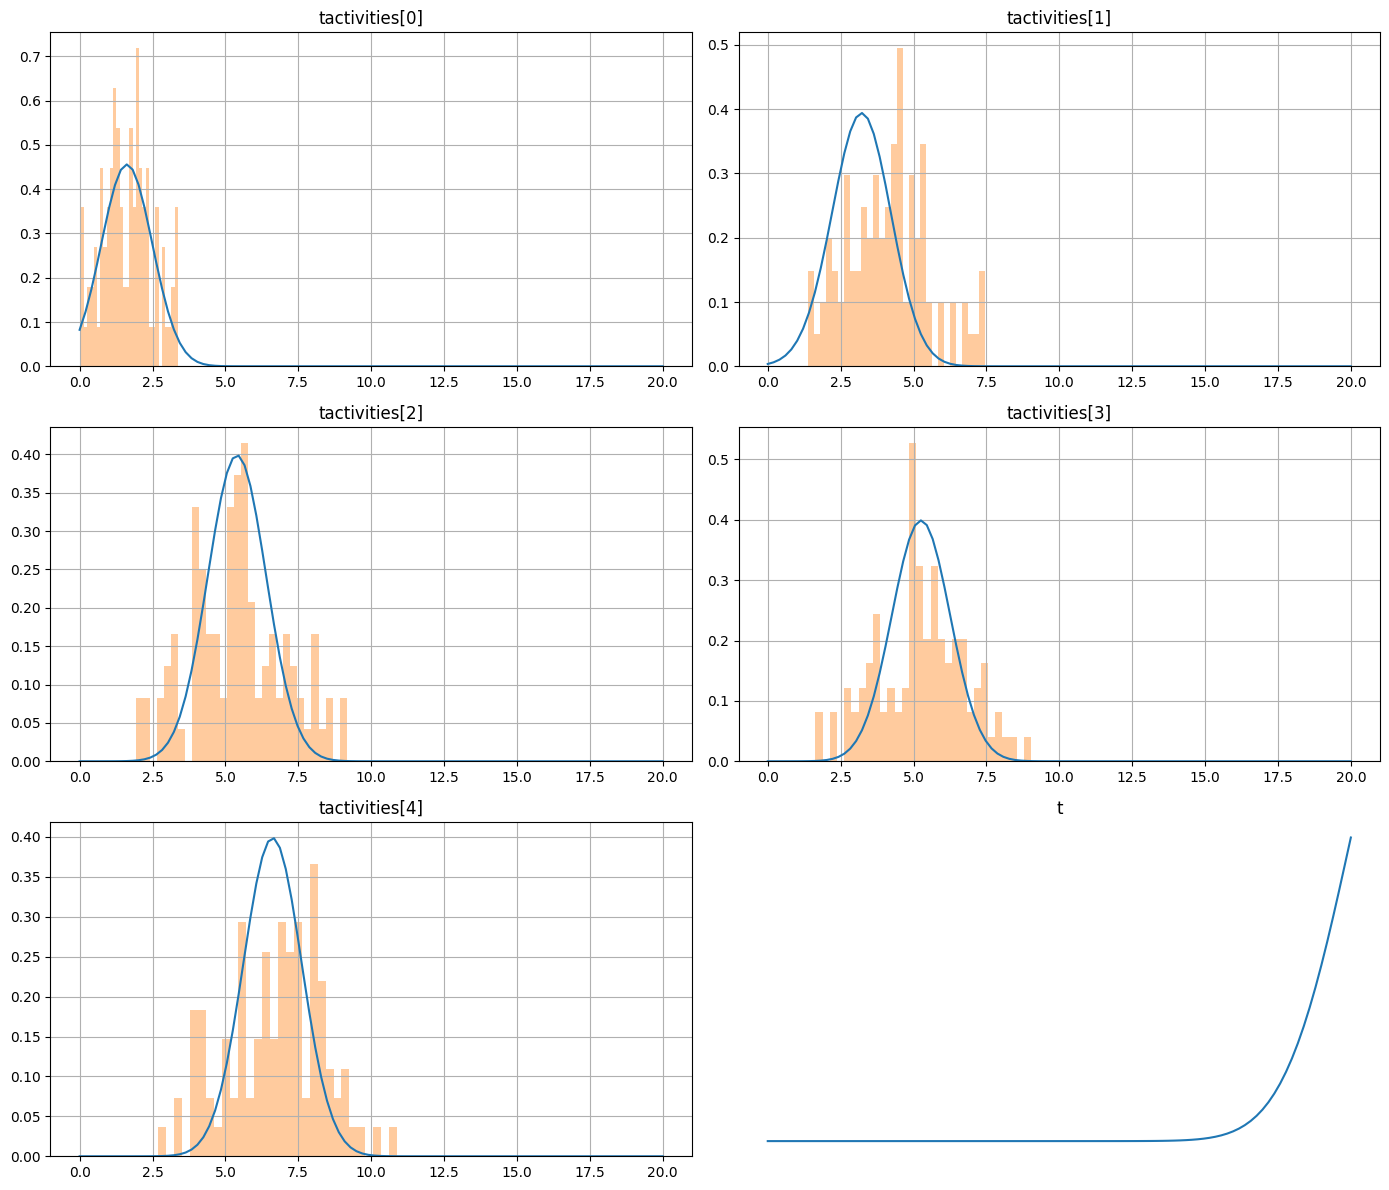

muinfo: 1.2139698732913593
mupayE: 1.5436195143032945
mupayS: 3.227980520770841
mupack: 2.3233252115780747
muprepinv: 2.2926011255526166
musendinv: 2.5723468458367584
resourcesrate: 0.6470517022688647
switch: 0.05682722395758896


In [16]:
params = {'muinfo':  2.,
          'mupayE':  1., 
          'mupayS':  3.,
          'mupack':  5., 
          'muprepinv':  4., 
          'musendinv':  2., 
          'resourcesrate': 0.5
          ,'switch': 0.4}

print("Initial parameters:")
# print params
for key, value in params.items():
    print(f"{key}: {value}")


for key in params:
    params[key] = params[key]**0.5

params_dict = initialize_params(params) 

#params_dict['mupack'].requires_grad = False
#params_dict['muprepinv'].requires_grad = False
#params_dict['muprepinv'].requires_grad = False
#params_dict['musendinv'].requires_grad = False

#params_dict['mupayE'].requires_grad = False
#params_dict['mupayS'].requires_grad = False
#params_dict['switch'].requires_grad = False

start_time = time.time()
# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=200, lr=0.01)

end_time = time.time()
execution_time = end_time - start_time
print(f"Optimization execution time: {execution_time} seconds")

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

output_dist = start_SOGA(cfg, params_dict)

hp.plot_pdf_with_histograms(
    output_dist,
    clean_durations,
    x_min=0.0,
    x_max=20.0,
    num_points=100
)
for key in params:
    params[key] = params[key]**2

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")
